In [1]:
import numpy as np
import pandas as pd
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein as lv
import multiprocessing as mp
import importlib.util,os,time
from sklearn import metrics
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [2]:
# functions

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def count_codons(file):
    '''codon frequency counter'''
    CodonsDict = {
        'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
        'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
        'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
        'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
        'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
        'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
        'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
        'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
        'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
        'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
        'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
        'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
        'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}
    
    # make the codon dictionary local
    codon_count = CodonsDict.copy()
    # iterate over sequence and count all the codons in the string.
    # make sure the sequence is upper case
    if str(file).islower():
        dna_sequence = str(file).upper()
    else:
        dna_sequence = str(file)
    for i in range(0, len(dna_sequence), 3):
        codon = dna_sequence[i:i + 3]
        if codon in codon_count:
            codon_count[codon] += 1
        else:
            #raise TypeError("illegal codon %s" % (codon))
            print("illegal codon %s" % (codon))
    # return values in dict with sorted keys alphabetically
    out=list()
    for key,value in sorted(codon_count.items()):
        out.append(value)
    
    return np.asarray(out)

def relative_relevance(in_replace,in_original):
    out = np.abs((in_original - in_replace)/in_original)
    return out


In [3]:
# data params
folder = '../data/'
names_plot = ['Promoter','5UTR','3UTR','Terminator']
limits = np.array([[0,400],[400,500],[500,750],[750,1000]])
label_names =["0_none", "1_low", "2_medium", "3_high"]
lmbda = 0.22
corrf = stats.spearmanr


### Single region models analysis

In [4]:
# load whole region
df_single = pd.read_csv(folder+'Optimization_singles_bal_subsample_64k.csv')
tmp = (pd.read_csv(folder+'Optimization_200d_bal_200k_dframe_seqs_subsample_64k.csv')
       .drop(columns=['Unnamed: 0','idx'])
      )
print(tmp.shape)
tmp['region'] = 'whole'
tmp.head()

df = df_single.append(tmp)

# calculate and plot also dynamic ranges separately
df = (df.merge((df.query('iter==100000')
                .query('y_tpm>=1') # remove outliers
    .groupby(['region'])
    .apply(lambda x: x.query('optimization=="max"').y_tpm.median()-
           x.query('optimization=="min"').y_tpm.median())
                         .rename('range_median')
                        )
                        ,left_on='region',right_index=True,how='left')
              )
df = (df.merge((df.query('iter>50000')
                .query('y_tpm>=1') # remove outliers
    .groupby(['region'])
    .apply(lambda x: x.query('optimization=="max"').y_tpm.max()-
           x.query('optimization=="min"').y_tpm.min())
                         .rename('range_max')
                        )
                        ,left_on='region',right_index=True,how='left')
              )

print(df.shape)
df.head()

(64126, 7)
(448894, 11)


,Unnamed: 0,seq,iter,model,optimization,region,latent,y_pred,y_tpm,range_median,range_max
0,200.0,ATTTGAAGACTCCACACATCAAGCATAAAAAGTAACATTTGAAGTA...,68800,3340,min,prom,"[-0.501637, -0.759638, -0.39410100000000003, 1...",5.479135,36.417892,239.904076,389.814122
1,131.0,TTTTGAAAACCGTCTCTTTCGATATTTCTAGTAGCCAGAATTCATA...,15800,3340,min,prom,"[0.386153, -1.010788, 1.299145, -1.23869799999...",6.039333,46.629242,239.904076,389.814122
2,378.0,TTACCTCTTCTCAGAATTCCATATTACCTTTCATTAGTCACGATTT...,47800,3340,max,prom,"[0.708792, 1.270001, -3.074129, 1.949114, -1.3...",11.590074,316.909850,239.904076,389.814122
3,53.0,TTCCAATCCTTTTCAATATATTCATATACCGTCCTCATCCTCAAAA...,94600,3340,max,prom,"[0.11594000000000002, -0.52872, 0.129435, 0.85...",12.553868,412.535950,239.904076,389.814122
4,63.0,TAAGTTGTCGTCTGCTGACCGTGAGAAAAAGATCAGGAAAGGCCAT...,48600,3340,min,prom,"[1.089545, 0.525092, 1.6915630000000001, -0.43...",5.733483,40.810970,239.904076,389.814122


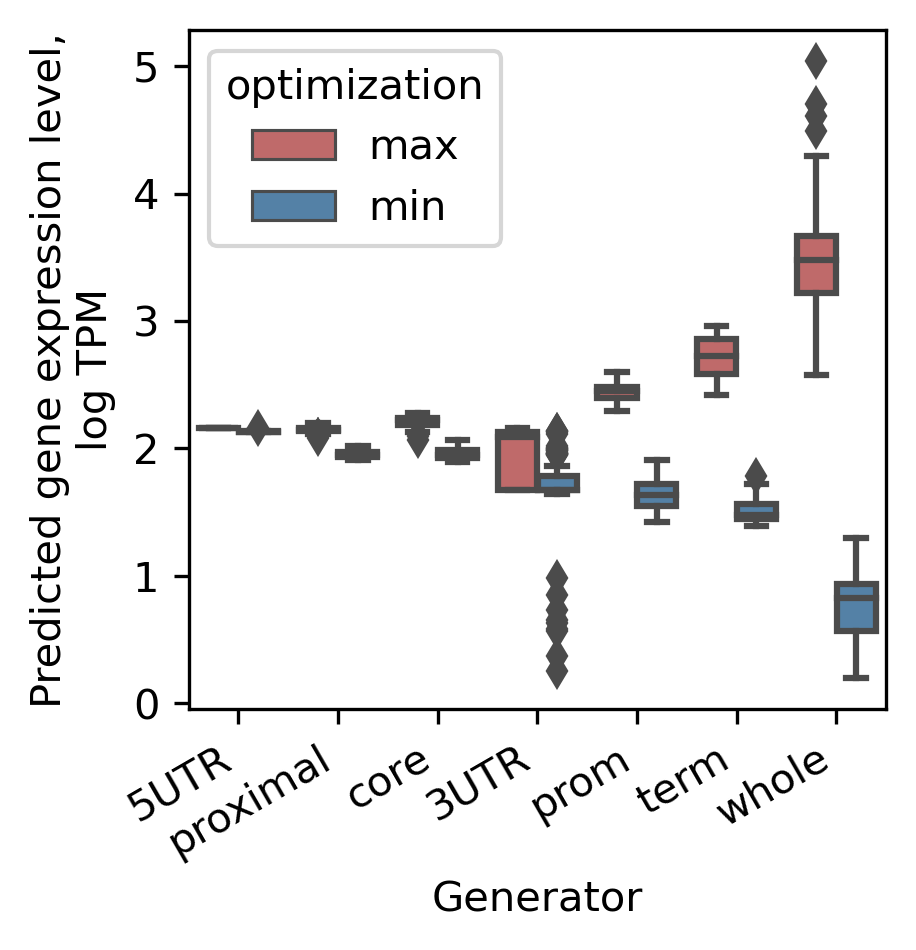

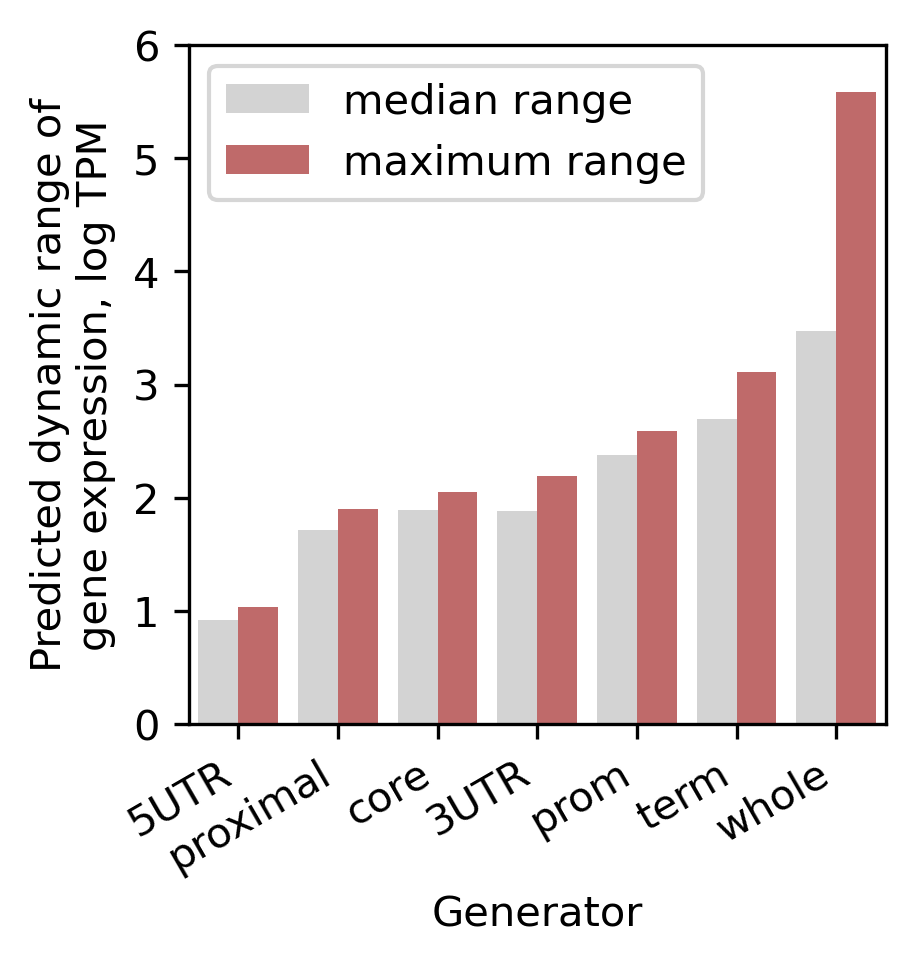

In [5]:
# plot unoptimized vs optimized distributions
# sort by dynamic range

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sort = (df
        .sort_values(by='range_max')
        [['region','range_median','range_max']]
        .drop_duplicates()
       )

df['ylog'] = np.log10(df.y_tpm)
sns.boxplot(data=df.query('iter==100000').query('y_tpm>=1'), # remove outliers
            x='region',y='ylog',hue='optimization',
            palette=['indianred','steelblue'],
            order=sort.region
           )
plt.xticks([0,1,2,3,4,5,6],['5UTR','proximal','core','3UTR','prom','term','whole'],
          rotation=30,ha='right'
          )
plt.ylabel('Predicted gene expression level,\nlog TPM')
plt.xlabel('Generator')
plt.show()

# median dynamic range
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sort['median range'] = np.log10(sort.range_median)
sort['maximum range'] = np.log10(sort.range_max)
sns.barplot(data=sort.melt(id_vars='region',value_vars=['median range','maximum range']),
            x='region',y='value',hue='variable',
           color='k',palette=['lightgrey','indianred'])
plt.xticks([0,1,2,3,4,5,6],['5UTR','proximal','core','3UTR','prom','term','whole'],
          rotation=30,ha='right'
          )
plt.legend(title='')
plt.ylim(0,6)
plt.ylabel('Predicted dynamic range of\ngene expression, log TPM')
plt.xlabel('Generator')
plt.show()


In [6]:
# values for text
# expression levels diff (TPM)
print(sort.query('region=="whole"')['range_median'].values/sort.query('region=="term"')['range_median'].values)
print(sort.query('region=="whole"')['range_median'].values/sort.query('region=="utr5"')['range_median'].values)

print(sort.query('region=="whole"')['range_max'].values/sort.query('region=="term"')['range_max'].values)
print(sort.query('region=="whole"')['range_max'].values/sort.query('region=="utr5"')['range_max'].values)

# dynamic range orders of magnitude diff
print(sort.query('region=="whole"')['median range'].values/sort.query('region=="term"')['median range'].values)
print(sort.query('region=="whole"')['median range'].values/sort.query('region=="utr5"')['median range'].values)

print(sort.query('region=="whole"')['maximum range'].values/sort.query('region=="term"')['maximum range'].values)
print(sort.query('region=="whole"')['maximum range'].values/sort.query('region=="utr5"')['maximum range'].values)

# specific proximal and 5utr
print(sort.query('region=="whole"')['median range'].values/sort.query('region=="utr5"')['median range'].values)
print(sort.query('region=="whole"')['median range'].values/sort.query('region=="deboer"')['median range'].values)

sort

[6.01077999]
[358.13006133]
[293.88983693]
[35337.18769836]
[1.28882603]
[3.77078269]
[1.7923569]
[5.39466678]
[3.77078269]
[2.02918703]


,region,range_median,range_max,median range,maximum range
256512,utr5,8.351720,10.837860,0.921776,1.034944
149629,deboer,51.631050,79.386370,1.712911,1.899746
128255,core,78.787980,113.382420,1.896460,2.054546
235137,utr3,75.914025,154.305835,1.880322,2.188382
0,prom,239.904076,389.814122,2.380038,2.590858
363392,term,497.606301,1303.139629,2.696886,3.114991
42751,whole,2991.001996,382979.493069,3.475817,5.583176


### Vaishnav2022 proximal promoter data

(24533, 8)
(10282,)


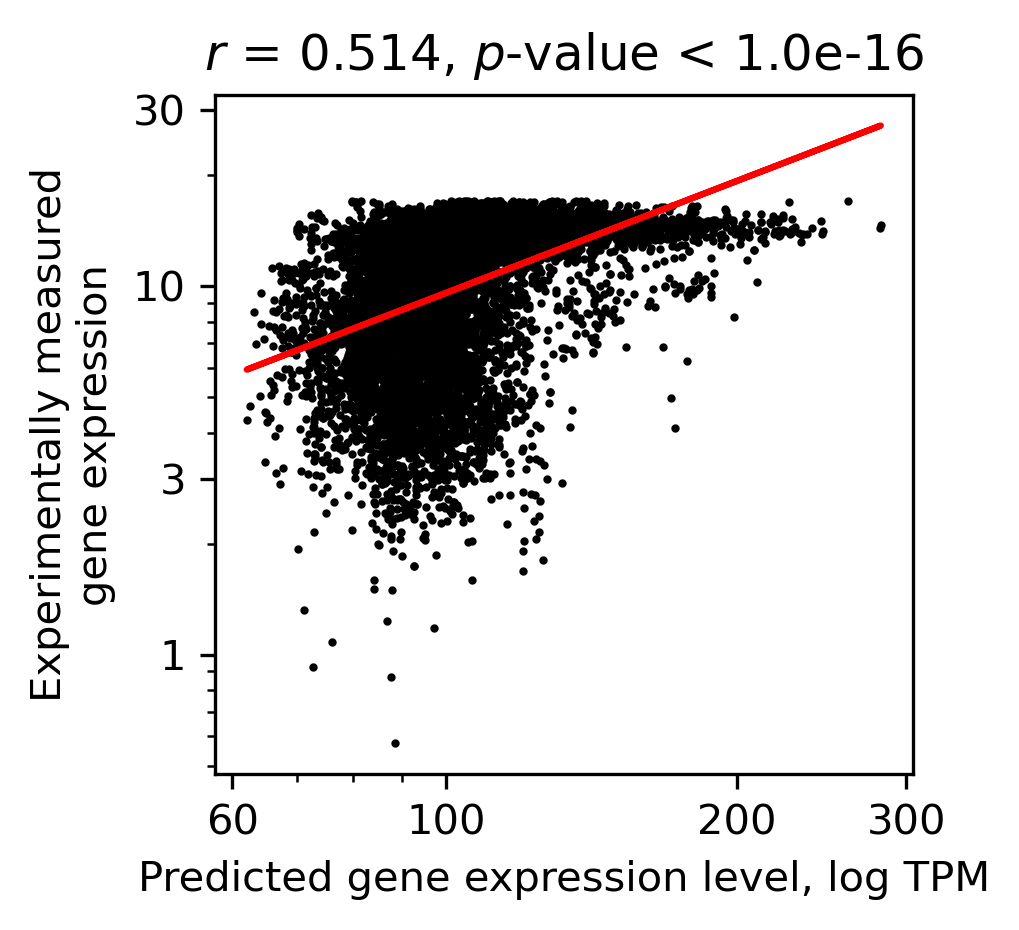

In [7]:
# load vaishnav 2022 data predictions
df_80 = pd.read_csv(folder+'df_80_predictions.csv')
print(df_80.shape)
df_80

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
y = df_80.query('media=="defined"')['Measured Expression'].values
x = df_80.query('media=="defined"').ytpm.values

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Experimentally measured\ngene expression')
plt.xlabel('Predicted gene expression level, log TPM')

plt.xticks([60,100,200,300],[60,100,200,300])
plt.yticks([1,3,10,30],[1,3,10,30])

r,p = stats.spearmanr(x,y)
plt.title('$r$ = '+str("%.3f" % r)+', $p$-value < '+str("%.1e" % fix_pvals(p)))

print(x.shape)
plt.show()

In [8]:
# load
df_80_constructs = pd.read_csv(folder+'df_80_constructs_predictions.csv')

# Add names high low for segregating plots
df_80_constructs.loc[df_80_constructs['Measured Expression']>10,'name'] = 'high'
df_80_constructs.loc[df_80_constructs['Measured Expression']<10,'name'] = 'low'
df_80_constructs.columns

# subselection, sort by medians
df_plot = (df_80_constructs
 .query('subset=="minmax"')
 .query('type=="sswm"')
 .query('media=="defined"')
 #.groupby('sequence').ytpm.var()
)

# reload data with indices
f = '../../../data/Vaishnav2022_data/SSWM_defined.csv'
tmp = pd.read_csv(f).drop(columns=['Unnamed: 0']).reset_index().rename(columns={'index':'seq_idx'})
tmp['type'] = f.split('/')[-1].split('_')[0].lower()
tmp['media'] = f.split('/')[-1].split('_')[1].split('.')[0].lower()
tmp['sequence']= tmp.sequence.apply(lambda x: x[17:97]) #.str.len()
tmp['seq_idx'] = tmp.seq_idx.astype('str')

df_plot = (df_plot
           .merge(tmp[['sequence','seq_idx']],on='sequence',how='left')
           .merge(df_plot.groupby('sequence')
                        .ytpm.median()
                        .astype('float')
                        .rename('med')
                        .reset_index(),
              on='sequence',how='left')
           .sort_values(by=['name','med'],ascending=[False,True])
          )

df_plot

,Unnamed: 0,sequence,Measured Expression,Predicted Expression,type,media,ypred_80,ytpm_80,constructs,ypred_reg,ytpm_reg,ypred,ytpm,subset,gene_id,name,seq_idx,med
19,431,AAGCTATTGAATAATGCTAATGTATGATATATTTATATTCTTCTTG...,2.176252,4.005012,sswm,defined,8.127265,105.69558,[[1 0 0 0]\n [1 0 0 0]\n [0 0 1 0]\n ...\n [1 ...,8.195252,108.297676,7.202308,74.893610,minmax,YLR410W,low,431,53.055035
153,431,AAGCTATTGAATAATGCTAATGTATGATATATTTATATTCTTCTTG...,2.176252,4.005012,sswm,defined,8.127265,105.69558,[[0 0 0 1]\n [0 0 1 0]\n [1 0 0 0]\n ...\n [0 ...,8.195252,108.297676,4.823974,26.784890,minmax,YMR177W,low,431,53.055035
287,431,AAGCTATTGAATAATGCTAATGTATGATATATTTATATTCTTCTTG...,2.176252,4.005012,sswm,defined,8.127265,105.69558,[[0 0 0 1]\n [1 0 0 0]\n [0 1 0 0]\n ...\n [0 ...,8.195252,108.297676,6.606440,59.113655,minmax,YGL201C,low,431,53.055035
421,431,AAGCTATTGAATAATGCTAATGTATGATATATTTATATTCTTCTTG...,2.176252,4.005012,sswm,defined,8.127265,105.69558,[[1 0 0 0]\n [1 0 0 0]\n [1 0 0 0]\n ...\n [1 ...,8.195252,108.297676,7.346655,79.168540,minmax,YNL066W,low,431,53.055035
555,431,AAGCTATTGAATAATGCTAATGTATGATATATTTATATTCTTCTTG...,2.176252,4.005012,sswm,defined,8.127265,105.69558,[[1 0 0 0]\n [0 0 1 0]\n [0 0 0 1]\n ...\n [0 ...,8.195252,108.297676,9.799877,185.689620,minmax,YER094C,low,431,53.055035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567306,1315,ATATTGCCGCATGCGCGCACACGGGGCTGAAAATCGGCCCCCTCCC...,16.942395,15.375881,sswm,defined,8.914054,138.98346,[[0 1 0 0]\n [0 1 0 0]\n [0 0 0 1]\n ...\n [0 ...,8.537068,122.146960,8.542694,122.385895,minmax,YJL205C,high,1315,187.549100
567440,1315,ATATTGCCGCATGCGCGCACACGGGGCTGAAAATCGGCCCCCTCCC...,16.942395,15.375881,sswm,defined,8.914054,138.98346,[[0 0 1 0]\n [0 0 0 1]\n [1 0 0 0]\n ...\n [0 ...,8.537068,122.146960,10.615688,238.767680,minmax,YEL047C,high,1315,187.549100
567574,1315,ATATTGCCGCATGCGCGCACACGGGGCTGAAAATCGGCCCCCTCCC...,16.942395,15.375881,sswm,defined,8.914054,138.98346,[[0 0 0 1]\n [1 0 0 0]\n [1 0 0 0]\n ...\n [0 ...,8.537068,122.146960,10.621676,239.196580,minmax,YNR048W,high,1315,187.549100
567708,1315,ATATTGCCGCATGCGCGCACACGGGGCTGAAAATCGGCCCCCTCCC...,16.942395,15.375881,sswm,defined,8.914054,138.98346,[[1 0 0 0]\n [1 0 0 0]\n [0 0 1 0]\n ...\n [0 ...,8.537068,122.146960,9.895193,191.364200,minmax,YER170W,high,1315,187.549100


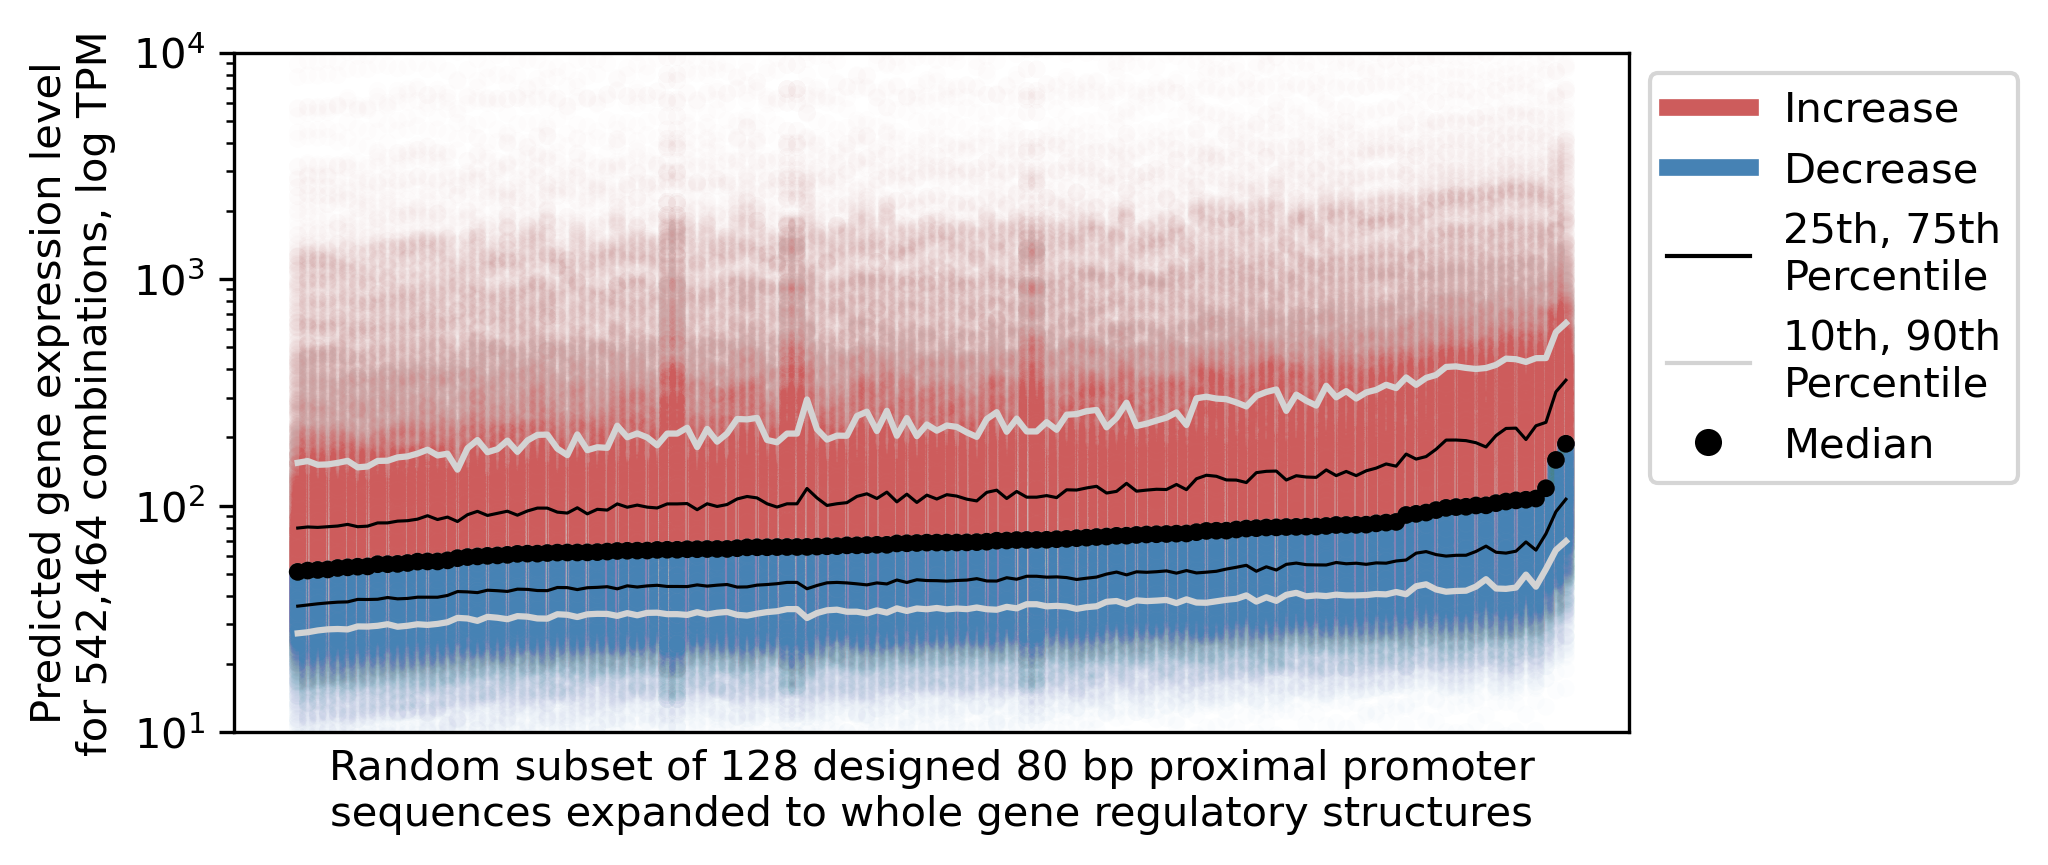

In [9]:
# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,3))

# basic overlays
sns.scatterplot(data=df_plot[['name','seq_idx','med']]
                .drop_duplicates().sort_values(by='med'),
           x='seq_idx',y='med',
           color='k',edgecolor='none',size=1
           )
sns.scatterplot(data=df_plot[['name','seq_idx','ytpm','med']]
                         .sort_values(by=['name','seq_idx']).reset_index(drop=True)
                         [df_plot.groupby(['name','seq_idx'])
                                .apply(lambda x: x.ytpm>x.med)
                          .droplevel(2).reset_index()[0]],
           x='seq_idx',y='ytpm',
           color='indianred',alpha=0.01,size=1
           )
sns.scatterplot(data=df_plot[['name','seq_idx','ytpm','med']]
                         .sort_values(by=['name','seq_idx']).reset_index(drop=True)
                         [df_plot.groupby(['name','seq_idx'])
                                .apply(lambda x: x.ytpm<x.med)
                          .droplevel(2).reset_index()[0]],
           x='seq_idx',y='ytpm',
           color='steelblue',alpha=0.01,size=1
           )

# main markings
sns.scatterplot(data=df_plot[['name','seq_idx','med']]
                .drop_duplicates().sort_values(by='med'),
           x='seq_idx',y='med',
           color='k',size=3,edgecolor='none'
           )
# quartiles
sns.lineplot(data=df_plot.groupby(['name','seq_idx'])
                .ytpm.quantile([0.75]).reset_index(),
           x='seq_idx',y='ytpm',
           color='k',
                size=1
           )
sns.lineplot(data=df_plot.groupby(['name','seq_idx'])
                .ytpm.quantile([0.25]).reset_index(),
           x='seq_idx',y='ytpm',
           color='k',
                size=1
           )
# 90,10%
sns.lineplot(data=df_plot.groupby(['name','seq_idx'])
                .ytpm.quantile([0.9]).reset_index(),
           x='seq_idx',y='ytpm',
           color='lightgrey',
                #size=1
           )
sns.lineplot(data=df_plot.groupby(['name','seq_idx'])
                .ytpm.quantile([0.1]).reset_index(),
           x='seq_idx',y='ytpm',
           color='lightgrey', 
                #size=1
           )

plt.yscale('log')
plt.xticks([],[],rotation=90) # keep ticks
plt.xlabel('Random subset of 128 designed 80 bp proximal promoter\nsequences expanded to whole gene regulatory structures') # 64 high and 64 low
plt.ylabel('Predicted gene expression level\nfor 542,464 combinations, log TPM')

#legend
#https://stackoverflow.com/questions/52111413/circle-in-the-legend-handle-doesnt-work-in-matplotlib
custom_lines = [Line2D([0], [0], color='indianred', lw=4),
                Line2D([0], [0], color='steelblue', lw=4),
                Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='lightgrey', lw=1),
                Line2D([0], [0], marker='o',color='w',markerfacecolor='k', markersize=7.5),
               ]
plt.legend(custom_lines, ['Increase',
                          'Decrease',
                         '25th, 75th\nPercentile',
                         '10th, 90th\nPercentile',
                         'Median',
                         ],bbox_to_anchor=(1,1)) 
#plt.legend().remove()
plt.ylim(1e1,1e4)
plt.show()


In [10]:
# inter 10-90 percentile range
print((df_plot.groupby(['name','seq_idx'])
       .ytpm.quantile([0.9]).apply(np.log10)
       .reset_index().ytpm).subtract
      (df_plot.groupby(['name','seq_idx'])
       .ytpm.quantile([0.1]).apply(np.log10)
       .reset_index().ytpm)
      .max()
     )


1.0164292382410718


### Cuperus2017 data

(200,)


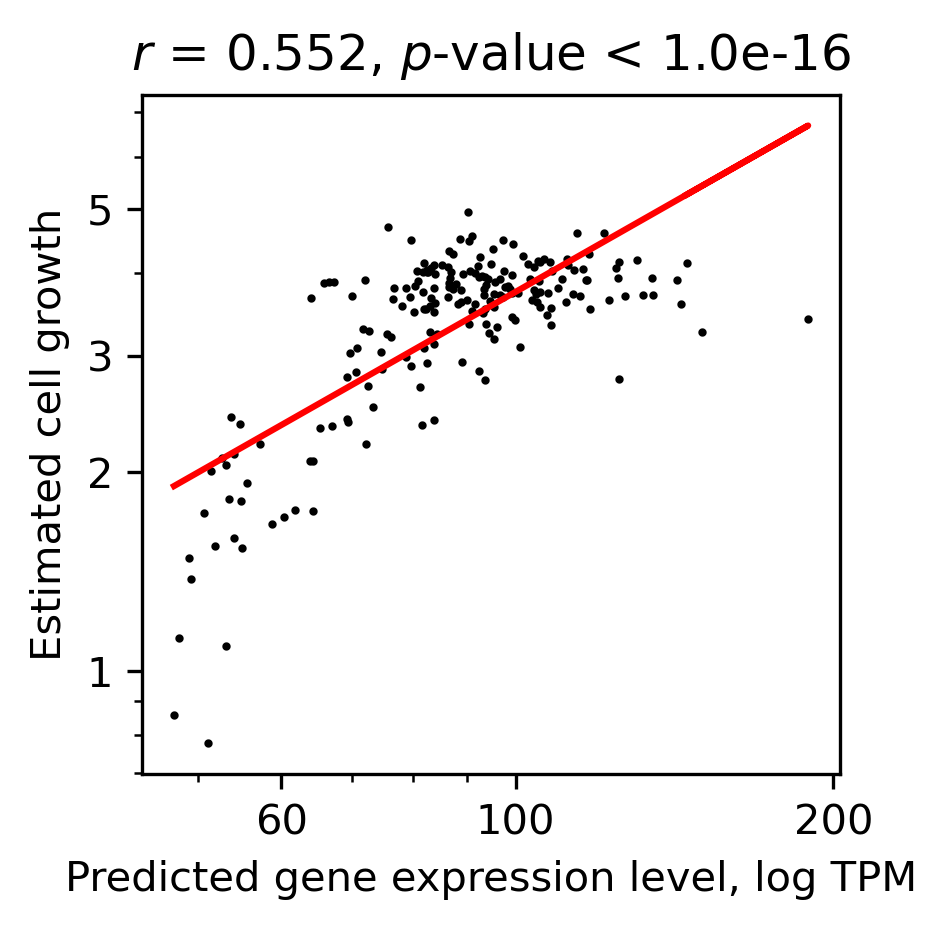

In [11]:
# load
df_5utr_constructs = pd.read_csv(folder+'df_5utr_constructs_predictions_full200.csv')

# plot
df_plot = df_5utr_constructs
df_plot = (df_plot
           .merge(df_plot.groupby('Evolved_Seq')
                        .ytpm.median()
                        .astype('float')
                        .rename('med')
                        .reset_index(),
              on='Evolved_Seq',how='left')
           .sort_values(by=['type','med'])
          )

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))

y = df_plot[['med','Pred_Growth']].drop_duplicates()['Pred_Growth'].values
x = df_plot[['med','Pred_Growth']].drop_duplicates().med.values

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Estimated cell growth')
plt.xlabel('Predicted gene expression level, log TPM')

plt.xticks([60,100,200],[60,100,200])
plt.yticks([1,2,3,5],[1,2,3,5])

r,p = stats.spearmanr(x,y)
plt.title('$r$ = '+str("%.3f" % r)+', $p$-value < '+str("%.1e" % fix_pvals(p)))

print(x.shape)
plt.show()

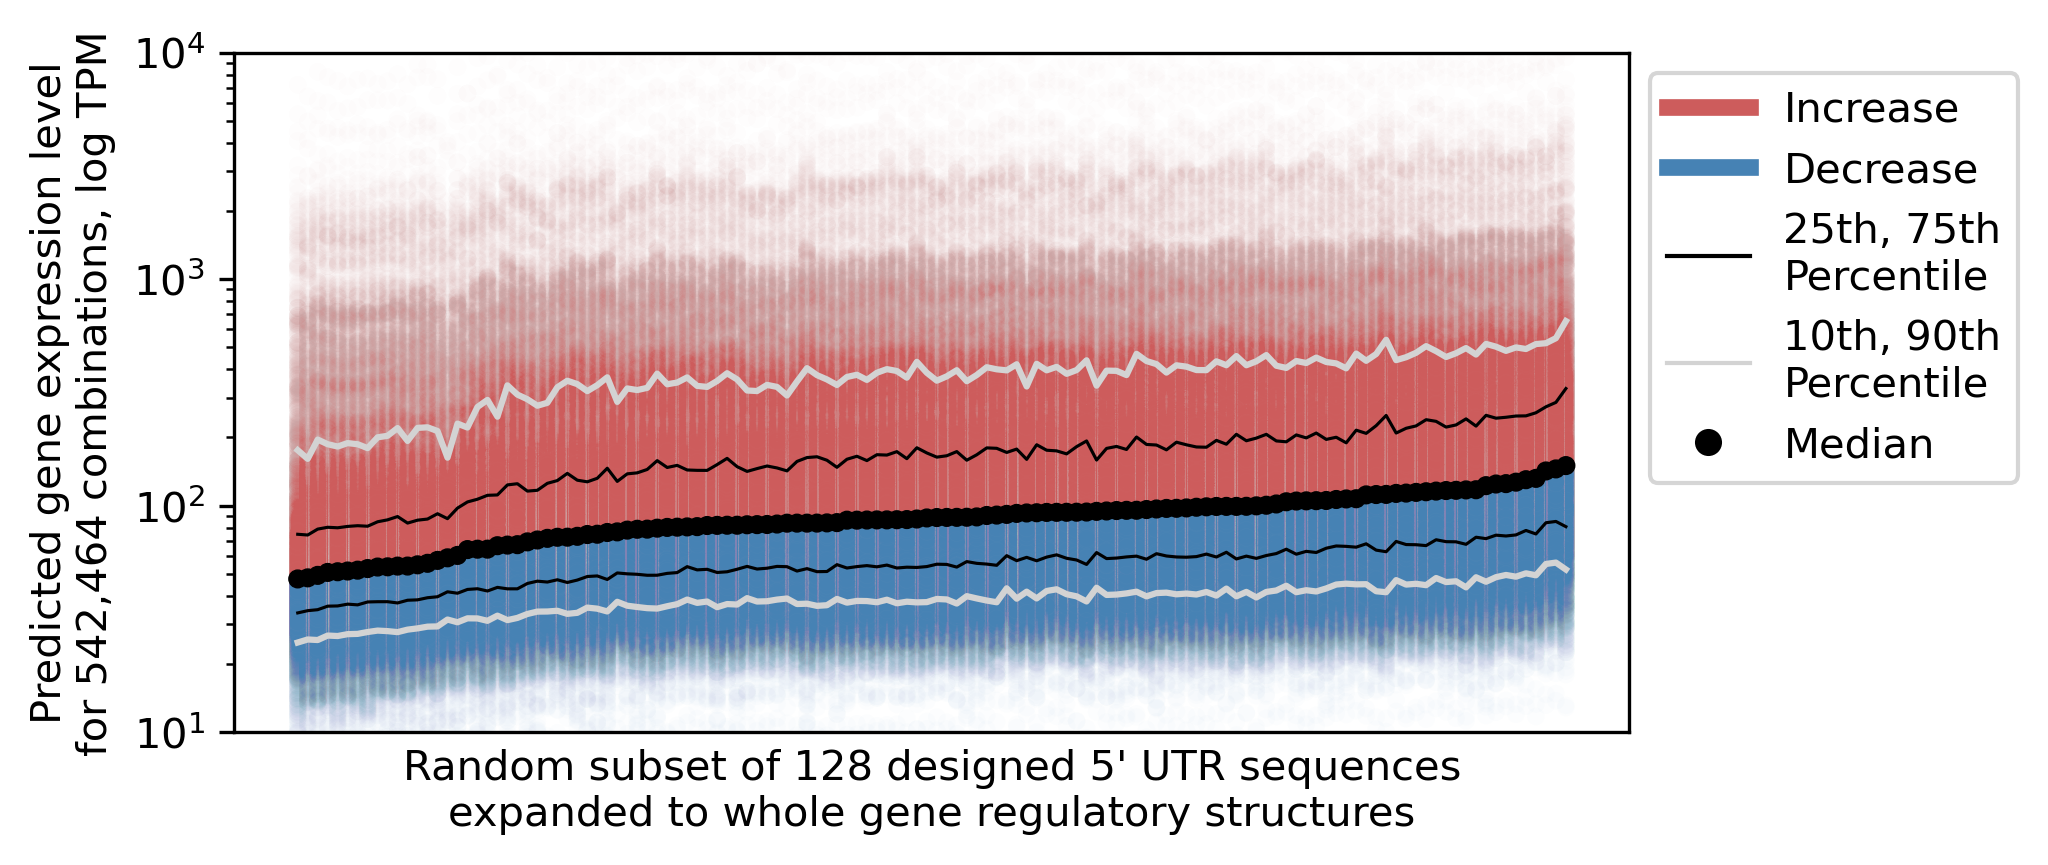

In [12]:
# load sampled 128
df_plot = pd.read_csv(folder+'df_5utr_constructs_predictions.csv')

# add r or n to index
df_plot['seq_idx2'] = df_plot.seq_idx.astype(str)+df_plot.type.apply(lambda x: x[0])

df_plot = (df_plot
           .merge(df_plot.groupby('Evolved_Seq')
                        .ytpm.median()
                        .astype('float')
                        .rename('med')
                        .reset_index(),
              on='Evolved_Seq',how='left')
           .sort_values(by=['type','med'])
          )

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,3))

# basic overlays
sns.scatterplot(data=df_plot[['type','seq_idx2','med']]
                .drop_duplicates().sort_values(by='med'),
           x='seq_idx2',y='med',
           color='k',size=1
           )
sns.scatterplot(data=df_plot[['type','seq_idx2','ytpm','med']]
                         .sort_values(by=['type','seq_idx2']).reset_index(drop=True)
                         [df_plot.groupby(['type','seq_idx2'])
                                .apply(lambda x: x.ytpm>x.med)
                          .droplevel(2).reset_index()[0]],
           x='seq_idx2',y='ytpm',
           color='indianred',alpha=0.01,size=1
           )
sns.scatterplot(data=df_plot[['type','seq_idx2','ytpm','med']]
                         .sort_values(by=['type','seq_idx2']).reset_index(drop=True)
                         [df_plot.groupby(['type','seq_idx2'])
                                .apply(lambda x: x.ytpm<x.med)
                          .droplevel(2).reset_index()[0]],
           x='seq_idx2',y='ytpm',
           color='steelblue',alpha=0.01,size=1
           )

# main markings
sns.scatterplot(data=df_plot[['type','seq_idx2','med']]
                .drop_duplicates().sort_values(by='med'),
           x='seq_idx2',y='med',
           color='k',size=3,edgecolor=None
           )
# quartiles
sns.lineplot(data=df_plot.groupby(['type','seq_idx2'])
                .ytpm.quantile([0.75]).reset_index(),
           x='seq_idx2',y='ytpm',
           color='k',
                size=1
           )
sns.lineplot(data=df_plot.groupby(['type','seq_idx2'])
                .ytpm.quantile([0.25]).reset_index(),
           x='seq_idx2',y='ytpm',
           color='k',
                size=1
           )
# 90,10%
sns.lineplot(data=df_plot.groupby(['type','seq_idx2'])
                .ytpm.quantile([0.9]).reset_index(),
           x='seq_idx2',y='ytpm',
           color='lightgrey',
                #size=1
           )
sns.lineplot(data=df_plot.groupby(['type','seq_idx2'])
                .ytpm.quantile([0.1]).reset_index(),
           x='seq_idx2',y='ytpm',
           color='lightgrey',
                #size=1
           )

plt.yscale('log')
plt.xticks([],[],rotation=90) # keep ticks
plt.xlabel("Random subset of 128 designed 5' UTR sequences\nexpanded to whole gene regulatory structures") # 64 high and 64 low"
plt.ylabel('Predicted gene expression level\nfor 542,464 combinations, log TPM')

#legend
#https://stackoverflow.com/questions/52111413/circle-in-the-legend-handle-doesnt-work-in-matplotlib
custom_lines = [Line2D([0], [0], color='indianred', lw=4),
                Line2D([0], [0], color='steelblue', lw=4),
                Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='lightgrey', lw=1),
                Line2D([0], [0], marker='o',color='w',markerfacecolor='k', markersize=7.5),
               ]
plt.legend(custom_lines, ['Increase',
                          'Decrease',
                         '25th, 75th\nPercentile',
                         '10th, 90th\nPercentile',
                         'Median',
                         ],bbox_to_anchor=(1,1)) 
#plt.legend().remove()
plt.ylim(1e1,1e4)
plt.show()


In [13]:
# inter 10-90 percentile range
print((df_plot.groupby(['type','seq_idx2'])
       .ytpm.quantile([0.9]).apply(np.log10)
       .reset_index().ytpm).subtract
      (df_plot.groupby(['type','seq_idx2'])
       .ytpm.quantile([0.1]).apply(np.log10)
       .reset_index().ytpm)
      .max()
     )


1.1145237270153376


### Different region combination effects

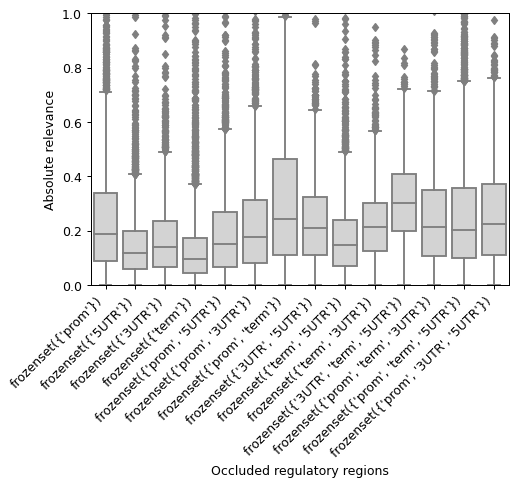

num_occ
1    0.128691
2    0.186961
3    0.240246
Name: rr, dtype: float64

In [14]:
# load
df_occ = pd.read_csv(folder+'region_combinations_relevance_analysis.csv')
df_occ['rr'] = relative_relevance(df_occ.box_occ.values,df_occ.box.values)

mpl.rcParams['figure.dpi'] = 90
sns.boxplot(data=df_occ,x='idx',y='rr',
           color = 'lightgrey')
plt.xticks(rotation=45,ha='right')
plt.ylim([0,1])
plt.ylabel('Absolute relevance')
plt.xlabel('Occluded regulatory regions')
plt.show()

df_occ.groupby('num_occ').rr.median()